<a href="https://colab.research.google.com/github/JackBstn/NLP/blob/main/chronos_multivariate_preprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Chronos adaptation to Multivariate Input: Preprocessing Multivariate Time Series

This notebook is designed to explore preprocessing techniques that transform multivariate time series data into univariate formats suitable for analysis with Chronos. It focuses on two primary preprocessing methods:
1. **Simple Transformation Methods**: Aggregating multiple variables into a single representative feature (Weighted Sum, Arithmetic Mean, Volume Weighted Average Price, PCA).
2. **Machine Learning-Based Methods**: Employ machine learning models to capture the underlying relationships among variables (Linear Regression, Random Forest, Support Vector Regression).

In this notebook, we apply these techniques to Apple stock market data, where the goal is to predict the Close price. The dataset includes multiple financial indicators (Open, High, Low, Volume, Close), and our preprocessing steps will transform these multivariate inputs into a univariate format, enabling the application of Chronos for forecasting. For comparison, we also evaluate Chronos using only the historical values of the Close price as input, without any transformation from multivariate data. This allows us to determine whether incorporating additional variables enhances forecasting performance.

The evaluation includes calculating various metrics such as MSE, RMSE, MAPE, and MASE,
and visualizing the forecast results to compare the performance of the fine-tuned model against the zero-shot model.

#### Install Dependencies

In [14]:
!pip install torch transformers chronos yfinance pandas matplotlib
!pip install git+https://github.com/amazon-science/chronos-forecasting.git

  Cloning https://github.com/amazon-science/chronos-forecasting.git to /tmp/pip-req-build-le8ajm9n
  Running command git clone --filter=blob:none --quiet https://github.com/amazon-science/chronos-forecasting.git /tmp/pip-req-build-le8ajm9n
  Resolved https://github.com/amazon-science/chronos-forecasting.git to commit 28e7b3281f68d1493a6290b3aa32902128ad2157
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [ ]:
import pandas as pd
import yfinance as yf
import torch
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from chronos import BaseChronosPipeline
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import gmean
from sklearn.metrics import mean_squared_error

### Utils

In [ ]:
# Function to compute MASE
def mase(y_true, y_pred, y_train):
    naive_forecast = np.abs(np.diff(y_train)).mean()  # Naive benchmark
    return np.mean(np.abs(y_true - y_pred)) / naive_forecast

# Function to compute evaluation metrics
def compute_metrics(y_true, y_pred, y_train):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    mase_score = mase(y_true, y_pred, y_train)
    return { "MSE": mse, "RMSE": rmse, "MAPE": mape, "MASE": mase_score }

# Function to compute the relative score
def agg_relative_score(model_df: pd.DataFrame, baseline_df: pd.DataFrame):
    relative_score = model_df / baseline_df  # Ratio between model and baseline
    return relative_score.agg(gmean)  # Geometric mean of improvements

## Pre-processing (from multivariate to univariate) using simple methods

In [ ]:
# Download data and Chronos model

# Set seed for reproducibility
seed = 343126
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)
np.random.seed(seed)

# Download data from Yahoo Finance (AAPL)
symbol = "AAPL"
data = yf.download(symbol, start="2023-09-01", end="2023-12-31", progress=False)
data_to_predict = yf.download(symbol, start="2024-01-01", end="2024-02-15", progress=False)
all_close_values = np.concatenate([data['Close'].values, data_to_predict['Close'].values])

# Standardize data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data[['Open', 'High', 'Low', 'Close', 'Volume']])

# Chronos model
pipeline = BaseChronosPipeline.from_pretrained(
    "amazon/chronos-t5-tiny",
    device_map="cuda",  # Usa "cpu" se non hai una GPU disponibile
    torch_dtype=torch.bfloat16,
)

In [ ]:
# Define the preprocessing methods

# Function to calculate PCA
def calculate_pca(data, scaler):
    pca = PCA(n_components=1)
    aapl_pca = pca.fit_transform(data)
    explained_variance = pca.explained_variance_ratio_[0]
    print(f"Explained Variance Ratio of the first component: {explained_variance}")
    return aapl_pca.flatten() * np.sqrt(pca.explained_variance_[0]) + scaler.mean_[3]  # Shift by Close mean

# Solution 1: Weighted Mean (Open, High, Low, Close)
weights = {'Open': 0.2, 'High': 0.3, 'Low': 0.3, 'Close': 0.2}
aapl_combined = (data['Open'] * weights['Open'] +
                 data['High'] * weights['High'] +
                 data['Low'] * weights['Low'] +
                 data['Close'] * weights['Close'])

# Solution 2: Arithmetic Mean (Open, High, Low, Close)
aapl_mean = data[['Open', 'High', 'Low', 'Close']].mean(axis=1)

# Solution 3: Volume Weighted Average Price (VWAP)
aapl_vwap = (data['Volume'] * (data['High'] + data['Low']) / 2).cumsum() / data['Volume'].cumsum()

# Solution 4: Principal Component Analysis (PCA)
aapl_pca_rescaled = calculate_pca(scaled_data, scaler)
aapl_pca_series = pd.Series(aapl_pca_rescaled, index=data.index)

Explained Variance Ratio of the first component: 0.8082937960477582
Weighted Mean (Open, High, Low, Close)
Variance: [ 387.398    536.2192   625.6955   804.7882   953.84045  825.9254
  978.5584  1039.0046  1174.649   1176.5692  1653.675   1972.8486
 2213.4082  2650.1216  2902.4233  3359.8743  3312.845   4365.923
 4575.758   4183.389   3869.052   4594.2383  5593.992   5645.203
 5350.7666  4527.435   3500.5723  2691.5103  2264.4946  2220.2808 ]


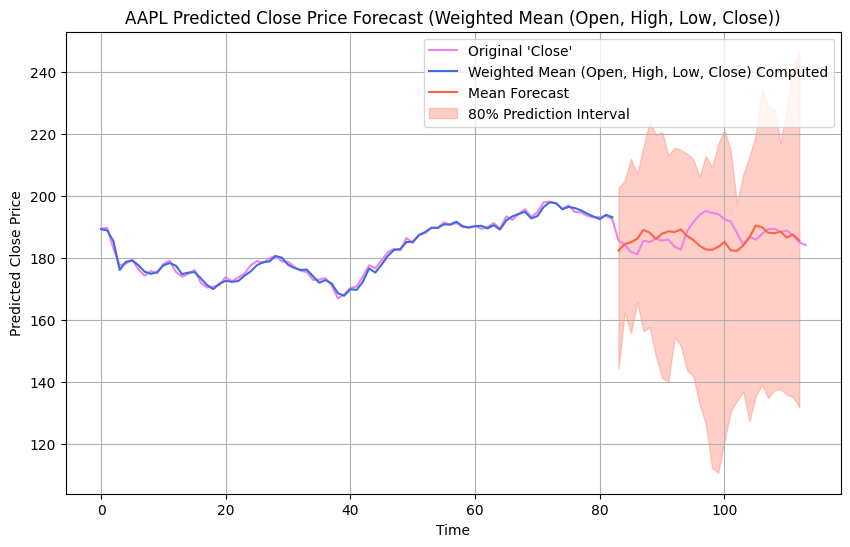

Arithmetic Mean
Variance: [  1.3049151   2.1300044   2.6187732   4.641132    9.667891   13.273163
  13.860582   14.147573   25.936443   32.622322   41.16012    59.45553
  88.71471    99.90717   118.072525  111.566     121.23384   140.42613
 127.3323    129.16183   131.11693   132.45766   135.70871   141.08974
 146.52455   155.30896   169.96777   179.6312    176.7479    188.9224   ]


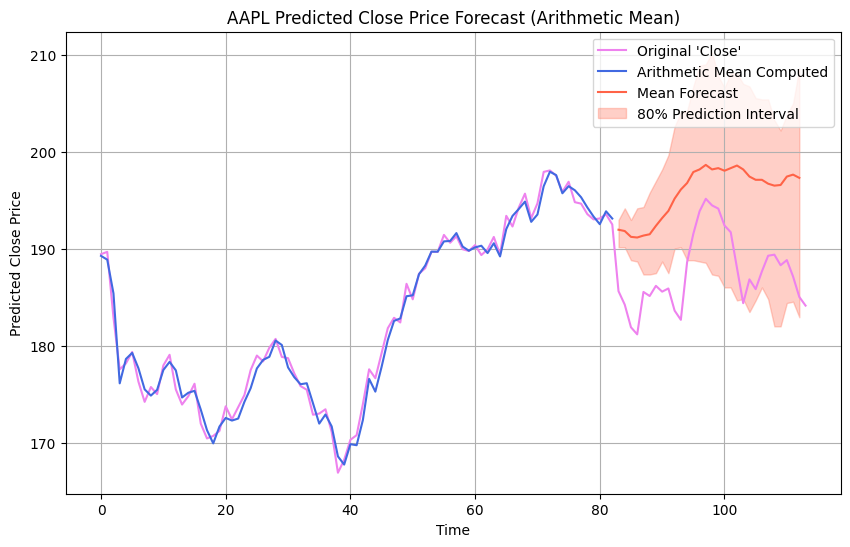

VWAP (Volume Weighted Average Price)
Variance: [335359.3  335853.2  337305.84 338195.75 337285.56 337944.25 339111.56
 343879.03 344364.06 344560.84 344823.56 345805.28 346189.6  346428.9
 346277.22 347451.75 347160.94 347686.94 347273.2  347970.1  348809.97
 349291.1  349444.06 349476.88 348732.75 347684.94 345765.34 341150.
 340620.88 340555.88]


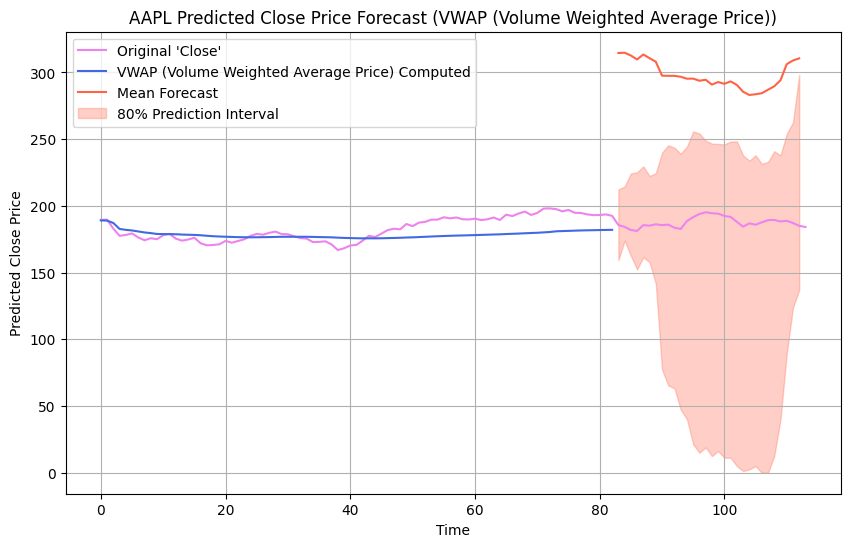

PCA Rescaled (Principal Component Analysis)
Variance: [ 0.53882426  1.4862444   1.8813803   1.5221704   2.2405965   3.3406875
  5.4600773   5.9989      7.561473    9.424898   10.776445   10.884214
 11.782267   11.9035015  10.075984   11.333242   15.71565    16.609196
 16.393673   16.93249    19.91398    19.218006   22.78769    23.780018
 28.216333   30.42548    27.731369   28.988628   29.864208   31.68272   ]


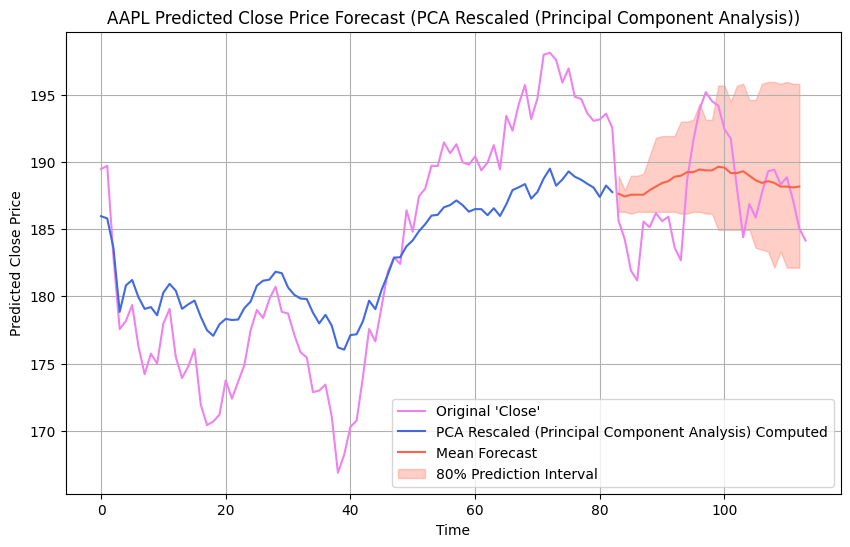

In [78]:
# Chronos prediction using only Close prices and using preprocessing methods

# Dictionary to store metrics
results = {}

# Chronos prediction using only Close prices
forecast_close = pipeline.predict(
    context=torch.tensor(data['Close'].values), prediction_length=30
)

# Extract forecast statistics
forecast_index_close = range(len(data['Close']), len(data['Close']) + 30)
low_close, median_close, high_close = np.quantile(forecast_close[0].numpy(), [0.1, 0.5, 0.9], axis=0)
mean_forecast_close = np.mean(forecast_close[0].numpy(), axis=0)

# Compute metrics for Chronos (Close-only)
actual_values = data_to_predict['Close'].values[:30]  # True values for comparison
results["Chronos Only Close"] = compute_metrics(actual_values, forecast_close, data['Close'].values)

# Chronos prediction using preprocessing methods
methods = {
    "Weighted Mean": aapl_combined,
    "Arithmetic Mean": aapl_mean,
    "VWAP (Volume Weighted Average Price)": aapl_vwap,
    "PCA Rescaled (Principal Component Analysis)": aapl_pca_series
}

for title, close_prices in methods.items():
    # Step 1: Chronos prediction
    forecast = pipeline.predict(
        context=torch.tensor(close_prices.values), prediction_length=30
    )

    # Step 2: Compute metrics
    results[title] = compute_metrics(actual_values, forecast, close_prices.values)

    # Step 3: Visualization
    forecast_index = range(len(close_prices), len(close_prices) + 30)
    low, median, high = np.quantile(forecast[0].numpy(), [0.1, 0.5, 0.9], axis=0)
    mean_forecast = np.mean(forecast[0].numpy(), axis=0)
    variance_forecast = np.var(forecast[0].numpy(), axis=0)

    print(f"{title}")
    print(f'Variance: {variance_forecast}')

    plt.figure(figsize=(10, 6))
    plt.plot(all_close_values, color="violet", label="True Close Prices")  # True Close Prices
    plt.plot(close_prices.values, color="royalblue", label=f"{title}")  # Close Prices using preprocessing methods

    # Predicted Close Prices using preprocessing methods
    plt.plot(forecast_index, mean_forecast, color="tomato", label=f"Predicted Close Prices (Preprocessing: {title})")
    plt.fill_between(forecast_index, low, high, color="tomato", alpha=0.3, label="80% Prediction Interval")

    # Add Chronos-only Close prediction
    plt.plot(forecast_index_close, mean_forecast_close, color="green", linestyle="dashed",
            label="Predicted Close Prices (Chronos Only Close)")
    plt.fill_between(forecast_index_close, low_close, high_close, color="green", alpha=0.2, label="Chronos 80% Prediction Interval")

    plt.title(f"{symbol} Predicted Close Price Forecast ({title})")
    plt.xlabel("Time")
    plt.ylabel("Predicted Close Price")
    plt.legend()
    plt.grid()
    plt.show()


# Convert results to DataFrame
results_df = pd.DataFrame(results).T
print("PERFORMANCE METRICS:")
print(results_df)

# Compute relative performance
relative_scores = agg_relative_score(results_df.iloc[1:], results_df.iloc[0])  # Exclude Chronos Only Close as baseline
print("-------------------------------------------------")
print("SCALING PERFORMANCE (Preprocessing vs Chronos Only Close):")
print(relative_scores)

## Pre-processing (from multivariate to univariate) using ML methods

Linear Regression Variance: [ 386.1115   534.43835  623.6177   802.11584  950.67303  823.1825
  975.3084  1035.5541  1170.748   1172.6619  1648.1829  1966.2969
 2206.0579  2641.3203  2892.7847  3348.7163  3301.843   4351.4233
 4560.562   4169.4956  3856.2026  4578.9805  5575.4146  5626.4546
 5332.997   4512.399   3488.9468  2682.5715  2256.974   2212.9072 ]


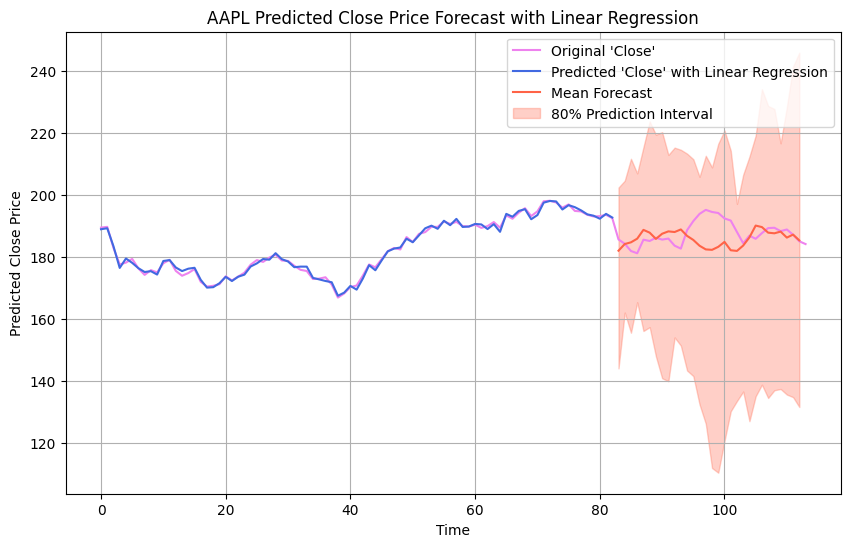

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Random Forest Variance: [  1.3291757   2.132962    4.131199    9.1425     13.700274   16.214912
  16.250835   15.896088   26.76289    32.797997   40.61128    60.87205
  87.5226    101.35306   121.76196   115.75828   125.17019   147.21368
 139.61133   123.95329   118.63218   105.520164  101.50124   100.33378
 113.1584    116.54862   128.94662   151.68613   148.62814   128.33154  ]


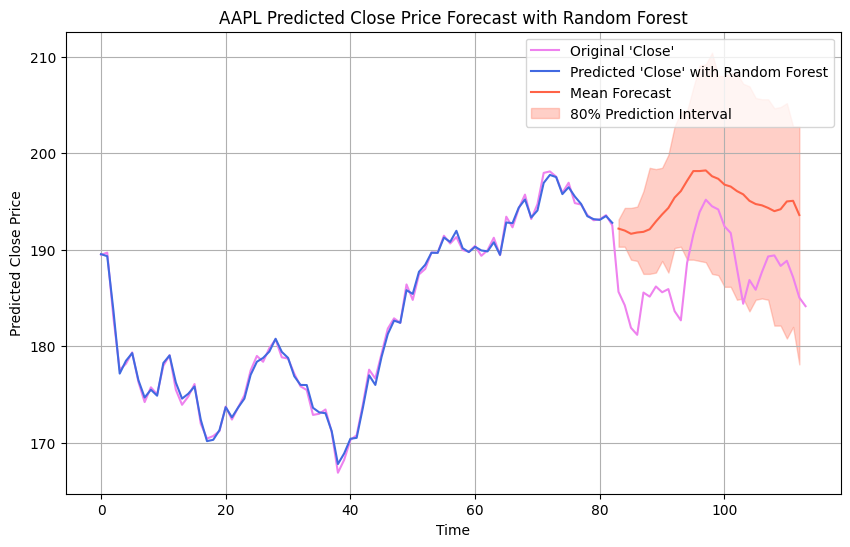

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Support Vector Regression Variance: [  1.6156919   3.1371226   6.727488    8.329688    7.5577683   6.9070005
  13.086939   18.539799   25.204416   30.24441    36.671173   40.117928
  47.48265    50.4627     49.955563   41.45084    38.66833    35.414562
  41.827847   41.307228   52.289257   70.38928    71.85686    83.853226
  86.09721    99.02255    96.47337    96.419525  105.24733   120.362816 ]


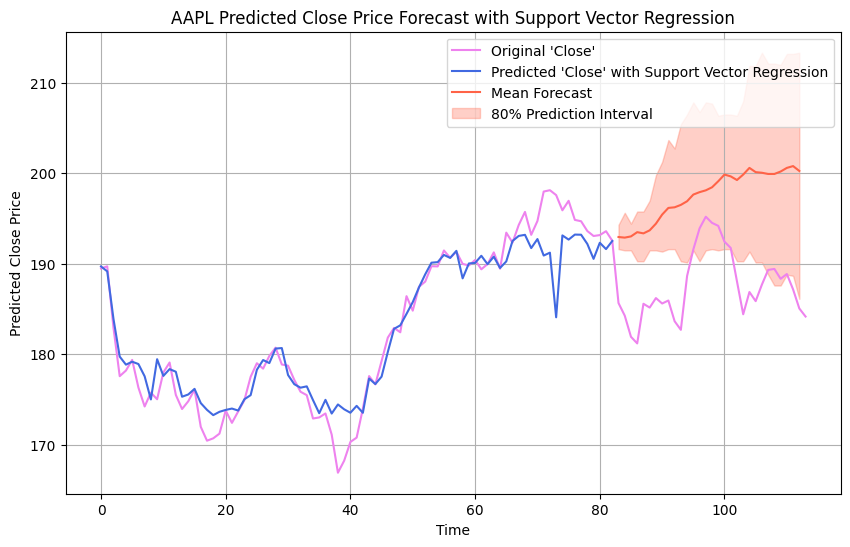

In [79]:
import pandas as pd
import yfinance as yf
import torch
from chronos import BaseChronosPipeline
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler

# Imposta il seed per riproducibilità
seed = 343126
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)
np.random.seed(seed)

# Scarica i dati da Yahoo Finance
symbol = "AAPL"
data = yf.download(symbol, start="2023-09-01", end="2023-12-31", progress=False)
data_to_predict = yf.download(symbol, start="2024-01-01", end="2024-02-15", progress=False)
close_to_predict = data_to_predict['Close']

# Preprocessamento dei dati
scaler = StandardScaler()
X = data[['Open', 'High', 'Low', 'Volume']].values
y = data['Close'].values
X_scaled = scaler.fit_transform(X)

# Modelli di regressione avanzata
models = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=seed),
    "Support Vector Regression": SVR(kernel='rbf')
}

# Modello Chronos per il forecasting
pipeline = BaseChronosPipeline.from_pretrained(
    "amazon/chronos-t5-tiny",
    device_map="cuda",  # Usa "cpu" se non hai una GPU disponibile
    torch_dtype=torch.bfloat16,
)

# Visualizza e confronta i risultati
all_close_values = np.concatenate([data['Close'].values, data_to_predict['Close'].values])
forecast_index = range(len(data), len(data) + 30)

for model_name, model in models.items():
    # Step 1: Fit del modello
    model.fit(X_scaled, y)

    # Previsione dei valori di Close
    predicted_close = model.predict(X_scaled)

    # Step 2: Forecasting con Chronos
    forecast = pipeline.predict(
        context=torch.tensor(predicted_close), prediction_length=30
    )

    # Step 3: Visualizzazione dei risultati
    low, median, high = np.quantile(forecast[0].numpy(), [0.1, 0.5, 0.9], axis=0)
    mean_forecast = np.mean(forecast[0].numpy(), axis=0)
    variance_forecast = np.var(forecast[0].numpy(), axis=0)

    print(f"{model_name} Variance: {variance_forecast}")

    # Plotting the forecast
    plt.figure(figsize=(10, 6))
    plt.plot(all_close_values, color="violet", label="Original 'Close'")
    plt.plot(predicted_close, color="royalblue", label=f"Predicted 'Close' with {model_name}")
    plt.plot(forecast_index, mean_forecast, color="tomato", label="Mean Forecast")
    plt.fill_between(forecast_index, low, high, color="tomato", alpha=0.3, label="80% Prediction Interval")
    plt.title(f"{symbol} Predicted Close Price Forecast with {model_name}")
    plt.xlabel("Time")
    plt.ylabel("Predicted Close Price")
    plt.legend()
    plt.grid()
    plt.show()
